In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [2]:
import fulu
import utils
from binned_split import binned_train_test_split

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [4]:
data = pd.read_csv('../data/plasticc/good_objects.csv.gz')

data = data[data.detected_bool == 1]

In [5]:
data.head()

,good_objects.csv,object_id,mjd,passband,flux,flux_err,detected_bool,log_lam,class
0,924.0,730.0,60532.3019,2.0,20.994711,1.047298,1.0,3.790512,0.0
1,926.0,730.0,60532.3173,3.0,31.523088,1.569497,1.0,3.875155,0.0
2,927.0,730.0,60532.3282,4.0,41.159981,2.310168,1.0,3.938479,0.0
3,928.0,730.0,60532.3392,5.0,46.795868,5.458707,1.0,3.987288,0.0
4,931.0,730.0,60535.2957,3.0,30.361010,2.107024,1.0,3.875155,0.0


In [6]:
object_ids = np.unique(data.object_id)

In [7]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Visual analysis

In [8]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [9]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [10]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject['log_lam'] = log_lam
    return anobject

In [11]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

In [12]:
def plot_light_curves_with_sigma(t, flux, flux_err, passband, title=""):
    colors = ['C'+str(i) for i in range(len(np.unique(passband)))]
    plt.figure(figsize=(9, 4))
    for i, pb in enumerate(np.unique(passband)):
        plt.plot(t[passband == pb], flux[passband == pb], linewidth=2., color=colors[i])
        plt.fill_between(t[passband == pb], 
                         flux[passband == pb]+1*flux_err[passband == pb], 
                         flux[passband == pb]-1*flux_err[passband == pb], label=passband2name[pb], alpha=0.5, color=colors[i])
    plt.xlabel('Time', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

13.0


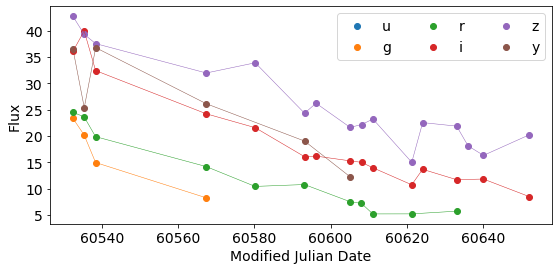

34.0


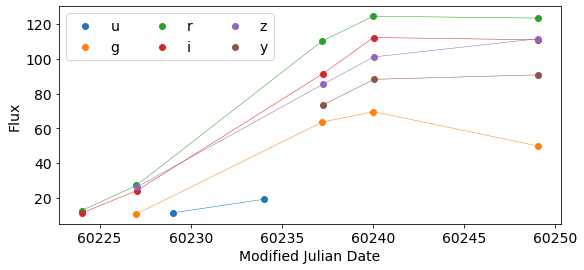

35.0


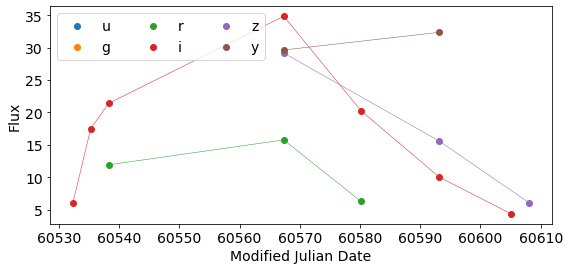

69.0


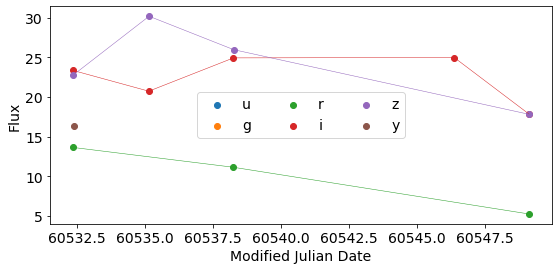

88.0


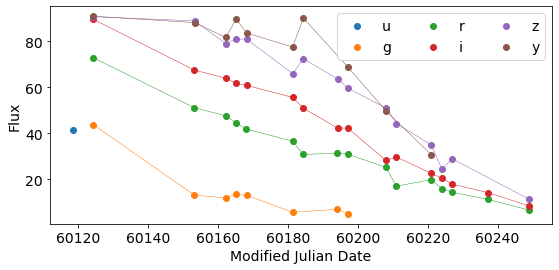

In [13]:
for i in object_ids[:5]:
    anobject = get_object(data, i)
    print(i)
    plot_light_curves(anobject)
    plt.show()

# One object test Test

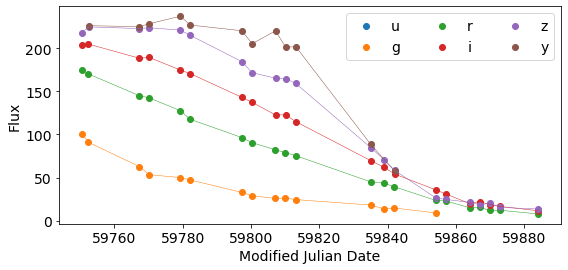

In [14]:
anobject = get_object(data, 329277) # 34299, 329277
anobject = add_log_lam(anobject)

plot_light_curves(anobject)
# plt.savefig('light_curve_34299.pdf', format='pdf')

RMSE:  7.436750558614648
MAE:  5.699373381694486
RSE:  0.10779419167374556
RAE:  0.0944688984822783
MAPE:  2.9240330963095005
NLPD:  3.333006211418047
nRMSEo:  1.8030356505571343
nRMSEp:  1.354402001658941
PICP@68:  0.42857142857142855
PICP@95:  0.7142857142857143


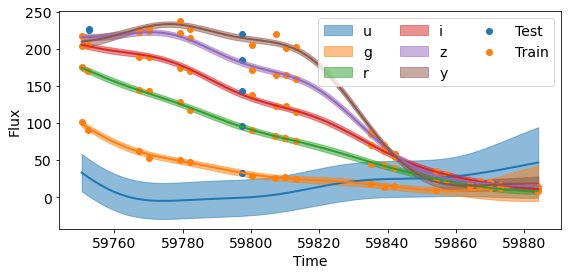

In [15]:
# train test split
t = anobject['mjd'].values
anobject_train, anobject_test = binned_train_test_split(anobject, 
                                                        t=t, 
                                                        bin_size=2, 
                                                        test_size=2, 
                                                        shuffle=True, 
                                                        random_state=42, 
                                                        bounds_in_train=True)


t_train = anobject_train['mjd'].values
flux_train = anobject_train['flux'].values
flux_err_train = anobject_train['flux_err'].values
passband_train = anobject_train['passband'].values

t_test = anobject_test['mjd'].values
flux_test = anobject_test['flux'].values
flux_err_test = anobject_test['flux_err'].values
passband_test = anobject_test['passband'].values

# approximation model
aug = fulu.GaussianProcessesAugmentation(passband2lam)
aug.fit(t_train, flux_train, flux_err_train, passband_train)

# augmentation
t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=1000)

# plotting
plot_light_curves_with_sigma(t_aug, flux_aug, flux_err_aug, passband_aug, title="")
plt.scatter(t_test, flux_test, label='Test')
plt.scatter(t_train, flux_train, label='Train')
plt.legend(loc='best', ncol=3, fontsize=14)

# calculate quality metrics
flux_pred_test, flux_err_pred_test = aug.predict(t_test, passband_test)
[rmse, mae, rse, rae, mape, nlpd, nrmseo, nrmsep, picp_68, picp_95] = utils.regression_quality_metrics_report(flux_test, flux_pred_test, 
                                                                                                              flux_err_test, flux_err_pred_test)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)
print("NLPD: ", nlpd)
print("nRMSEo: ", nrmseo)
print("nRMSEp: ", nrmsep)
print("PICP@68: ", picp_68)
print("PICP@95: ", picp_95)

# Test on many objects

In [16]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 7 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 7:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

In [17]:
from joblib import Parallel, delayed

In [18]:
def gen_report(metrics):
    report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'NLPD', 'nRMSEo', 'nRMSEp', 'PICP_68', 'PICP_95'])
    for i, met in enumerate(metrics):
        if met is not None:
            report.loc[len(report), :] = [i] + list(met)
    n_failed = report[report.MAE == -999].shape[0]
    print("Num. of failed curves: ", n_failed)
    report = report[report.MAE != -999]
    return report

In [19]:
def one_object_run(i):
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    # take only good curves
    if not is_good(anobject): 
        return None
    
    # train test split
    t = anobject['mjd'].values
    try:
        anobject_train, anobject_test = binned_train_test_split(anobject, 
                                                            t=t, 
                                                            bin_size=2, 
                                                            test_size=2, 
                                                            shuffle=True, 
                                                            random_state=42, 
                                                            bounds_in_train=True)
    
    except:
        print(i, len(anobject), t.max()-t.min())
        return [-999] * 10

    t_train = anobject_train['mjd'].values
    flux_train = anobject_train['flux'].values
    flux_err_train = anobject_train['flux_err'].values
    passband_train = anobject_train['passband'].values

    t_test = anobject_test['mjd'].values
    flux_test = anobject_test['flux'].values
    flux_err_test = anobject_test['flux_err'].values
    passband_test = anobject_test['passband'].values
    
    # approximation model
    if MODEL == "GP":
        aug = fulu.GaussianProcessesAugmentation(passband2lam)
    elif MODEL == "NN_sklearn":
        aug = fulu.MLPRegressionAugmentation(passband2lam)
    elif MODEL == "NN_pytorch":
        aug = fulu.SingleLayerNetAugmentation(passband2lam)
    elif MODEL == "BNN":
        aug = fulu.BayesianNetAugmentation(passband2lam)
    elif MODEL == "NF":
        aug = fulu.NormalizingFlowAugmentation(passband2lam)

    # fit the model
    aug.fit(t_train, flux_train, flux_err_train, passband_train)

    # calculate quality metrics
    flux_pred_test, flux_err_pred_test = aug.predict(t_test, passband_test)
    metrics = utils.regression_quality_metrics_report(flux_test, flux_pred_test, flux_err_test, flux_err_pred_test)
    
    return metrics

In [20]:
%%time

MODEL = "GP"
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_gp = gen_report(metrics)
report_gp.mean()

Num. of failed curves:  0
CPU times: user 1min 52s, sys: 8.73 s, total: 2min
Wall time: 4min 45s


ID         60997.335563
RMSE          46.069039
MAE           37.013516
RSE            1.086243
RAE            0.970794
MAPE          22.729705
NLPD           4.721476
nRMSEo         5.609766
nRMSEp         1.147446
PICP_68        0.700434
PICP_95        0.884996
dtype: float64

In [21]:
%%time

MODEL = "NN_sklearn"
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_sk = gen_report(metrics)
report_sk.mean()

Num. of failed curves:  0
CPU times: user 1min 46s, sys: 8.49 s, total: 1min 54s
Wall time: 3min 18s


ID         60997.335563
RMSE          43.237992
MAE           34.295625
RSE            1.077360
RAE            0.971937
MAPE          19.596025
NLPD          65.718696
nRMSEo         5.162682
nRMSEp         4.788448
PICP_68        0.382068
PICP_95        0.587564
dtype: float64

In [22]:
%%time

MODEL = "NN_pytorch"
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_pt = gen_report(metrics)
report_pt.mean()

Num. of failed curves:  0
CPU times: user 3min 36s, sys: 15.2 s, total: 3min 52s
Wall time: 13min 5s


ID         60997.335563
RMSE          60.716536
MAE           47.906924
RSE            1.253062
RAE            1.132817
MAPE          21.389448
NLPD          78.359135
nRMSEo         5.661704
nRMSEp         4.576333
PICP_68        0.399010
PICP_95        0.603106
dtype: float64

In [23]:
%%time

MODEL = "BNN"
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_bn = gen_report(metrics)
report_bn.mean()

Num. of failed curves:  0
CPU times: user 7min 8s, sys: 27.9 s, total: 7min 36s
Wall time: 1h 4min 15s


ID         60997.335563
RMSE          47.990783
MAE           38.768748
RSE            1.350182
RAE            1.252069
MAPE          22.011520
NLPD          88.955622
nRMSEo         6.038062
nRMSEp         8.768906
PICP_68        0.175691
PICP_95        0.320563
dtype: float64

In [24]:
%%time

MODEL = "NF"
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_nf = gen_report(metrics)
report_nf.mean()

Num. of failed curves:  0
CPU times: user 11min 34s, sys: 40.6 s, total: 12min 15s
Wall time: 4h 44min 18s


ID         60997.335563
RMSE          35.858241
MAE           27.600378
RSE            0.892607
RAE            0.803367
MAPE          16.681793
NLPD           7.067605
nRMSEo         3.994442
nRMSEp         1.793451
PICP_68        0.558360
PICP_95        0.812658
dtype: float64